In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

from tvDatafeed import TvDatafeed, Interval

In [73]:
tv = TvDatafeed()

In [74]:
# index
comb = tv.get_hist(symbol='COMB.N0000',exchange='CSELK',interval=Interval.in_daily,n_bars=10000)

In [83]:
# Example NumPy array (replace this with your actual data)
data = np.array(comb)

# Convert the NumPy array to a DataFrame
columns = ["symbol", "open", "high", "low", "close", "volume"]
df = pd.DataFrame(data, columns=columns)

# Convert relevant columns to numeric
df["open"] = df["open"].astype(float)
df["high"] = df["high"].astype(float)
df["low"] = df["low"].astype(float)
df["close"] = df["close"].astype(float)
df["volume"] = df["volume"].astype(float)

# Ensure the DataFrame index is a DatetimeIndex
df['date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
df.set_index('date', inplace=True)


# Use all features for prediction
features = ["open", "high", "low", "close", "volume"]
target = "close"

In [84]:
# Preprocess the data
def preprocess_data(df, features, target, time_steps=60):
    if len(df) < time_steps + 1:
        raise ValueError(f"Not enough data to create sequences. Required: {time_steps + 1}, Available: {len(df)}")
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[features])
    
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, :])
        y.append(scaled_data[i, features.index(target)])
    
    return np.array(X), np.array(y), scaler

In [85]:
# Define time steps and preprocess data
time_steps = 5  # Reduced for demonstration
try:
    X, y, scaler = preprocess_data(df, features, target, time_steps)
except ValueError as e:
    print(e)
    exit()

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [86]:
# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(50),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [87]:
# Create and train the model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0526 - val_loss: 0.0013
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033 - val_loss: 9.6104e-04
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022 - val_loss: 9.7568e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 9.0116e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 8.7483e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0010 - val_loss: 9.5528e-04
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms

In [88]:
# Function to predict future prices
def predict_future_prices(model, last_sequence, scaler, time_steps, future_days):
    predictions = []
    current_sequence = last_sequence[-time_steps:].copy()
    
    for _ in range(future_days):
        next_prediction = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        predictions.append(next_prediction)
        
        new_row = np.append(current_sequence[-1, 1:], next_prediction).reshape(1, -1)
        current_sequence = np.vstack([current_sequence, new_row])
        current_sequence = current_sequence[1:]
    
    predictions = np.array(predictions).reshape(-1, 1)
    close_scaler = MinMaxScaler()
    close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index(target)], scaler.scale_[features.index(target)]
    predictions = close_scaler.inverse_transform(predictions)
    return predictions

In [89]:
# Predict prices for different time frames
last_sequence = X_test[-1]  # Use the last sequence from the test data
future_days = 30  # Predict for the next 30 days
predictions = predict_future_prices(model, last_sequence, scaler, time_steps, future_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

C:\Users\LENOVO\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


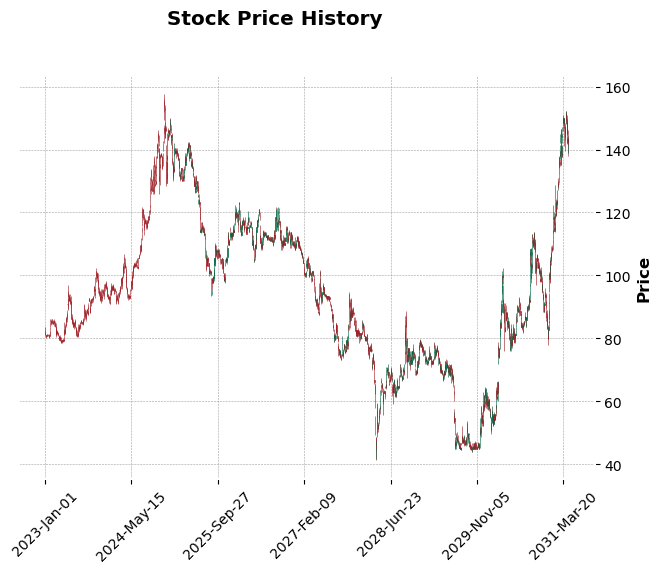

ValueError: O,H,L,C must have the same amount of missing data!

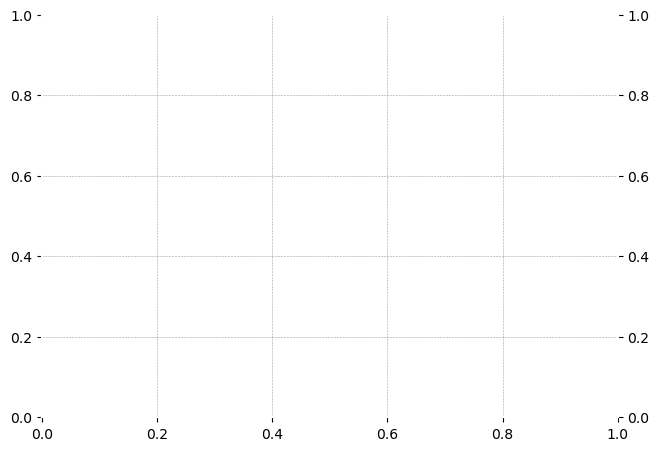

In [90]:
# Convert predictions into DataFrame
dates = pd.date_range(start=df.index[-1], periods=future_days + 1, freq='D')[1:]
pred_df = pd.DataFrame(predictions, columns=["close"], index=dates)
pred_df["open"] = pred_df["close"].shift(1)
pred_df["high"] = pred_df[["open", "close"]].max(axis=1)
pred_df["low"] = pred_df[["open", "close"]].min(axis=1)
pred_df["volume"] = 0  # No volume for predictions

# Plot original data as candlestick
mpf.plot(df.set_index(df.index), type='candle', style='charles', title="Stock Price History", ylabel="Price")

# Plot future predictions as candlestick
mpf.plot(pred_df, type='candle', style='charles', title="Future Price Prediction", ylabel="Price")


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0512 - val_loss: 9.4125e-04
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0024 - val_loss: 7.5715e-04
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0019 - val_loss: 8.1465e-04
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 9.6215e-04
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - val_loss: 7.3087e-04
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 9.7818e-04
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012 - val_loss: 9.0218e-04
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 8.5713e-04
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.4462e-04 - val_loss: 9.3144e-04
Epoch 12/50
76/76 ━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


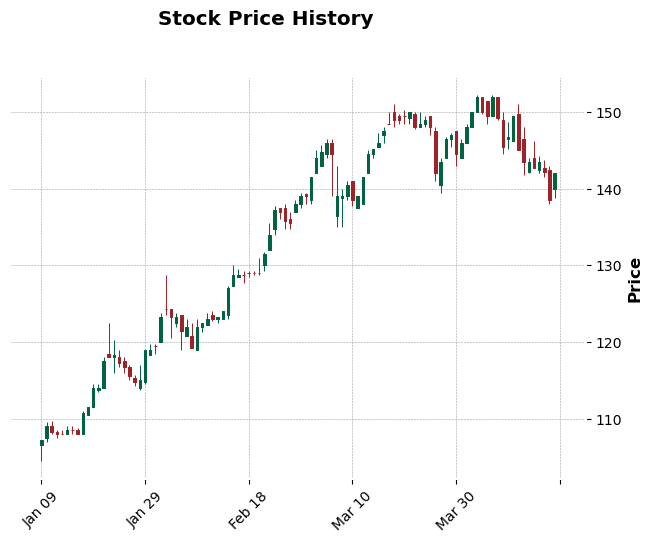

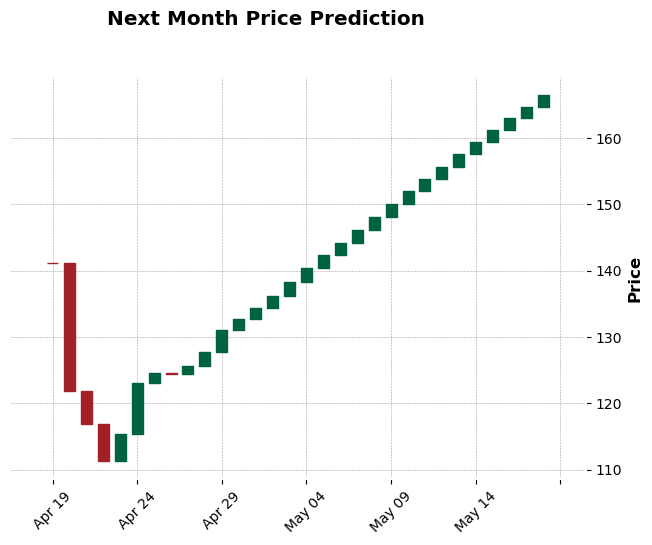

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Example NumPy array (replace this with your actual data)
data = np.array(comb)

# Convert the NumPy array to a DataFrame
columns = ["symbol", "open", "high", "low", "close", "volume"]
df = pd.DataFrame(data, columns=columns)

# Convert relevant columns to numeric
df["open"] = df["open"].astype(float)
df["high"] = df["high"].astype(float)
df["low"] = df["low"].astype(float)
df["close"] = df["close"].astype(float)
df["volume"] = df["volume"].astype(float)

# Ensure the DataFrame index is a DatetimeIndex
df['date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
df.set_index('date', inplace=True)

# Use all features for prediction
features = ["open", "high", "low", "close", "volume"]
target = "close"

# Preprocess the data
def preprocess_data(df, features, target, time_steps=60):
    if len(df) < time_steps + 1:
        raise ValueError(f"Not enough data to create sequences. Required: {time_steps + 1}, Available: {len(df)}")
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[features])
    
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, :])
        y.append(scaled_data[i, features.index(target)])
    
    return np.array(X), np.array(y), scaler

# Define time steps and preprocess data
time_steps = 5  # Reduced for demonstration
try:
    X, y, scaler = preprocess_data(df, features, target, time_steps)
except ValueError as e:
    print(e)
    exit()

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100, return_sequences=False),
        Dropout(0.3),
        Dense(50),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

# Create and train the model
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Function to predict future prices
def predict_future_prices(model, last_sequence, scaler, time_steps, future_days):
    predictions = []
    current_sequence = last_sequence[-time_steps:].copy()
    
    for _ in range(future_days):
        next_prediction = model.predict(current_sequence[np.newaxis, :, :])[0, 0]
        predictions.append(next_prediction)
        
        new_row = np.append(current_sequence[-1, 1:], next_prediction).reshape(1, -1)
        current_sequence = np.vstack([current_sequence, new_row])
        current_sequence = current_sequence[1:]
    
    predictions = np.array(predictions).reshape(-1, 1)
    close_scaler = MinMaxScaler()
    close_scaler.min_, close_scaler.scale_ = scaler.min_[features.index(target)], scaler.scale_[features.index(target)]
    predictions = close_scaler.inverse_transform(predictions)
    return predictions

# Predict prices for the next month (30 days)
last_sequence = X_test[-1]  # Use the last sequence from the test data
future_days = 30  # Predict for the next 30 days
predictions = predict_future_prices(model, last_sequence, scaler, time_steps, future_days)

# Convert predictions into DataFrame
dates = pd.date_range(start=df.index[-1], periods=future_days + 1, freq='D')[1:]
pred_df = pd.DataFrame(predictions, columns=["close"], index=dates)
pred_df["open"] = pred_df["close"].shift(1)
pred_df["open"].fillna(pred_df["close"].iloc[0], inplace=True)
pred_df["high"] = pred_df[["open", "close"]].max(axis=1)
pred_df["low"] = pred_df[["open", "close"]].min(axis=1)
pred_df["volume"] = 0  # No volume for predictions

# Plot original data as candlestick
mpf.plot(df[-100:], type='candle', style='charles', title="Stock Price History", ylabel="Price")

# Plot future predictions as candlestick
mpf.plot(pred_df.dropna(), type='candle', style='charles', title="Next Month Price Prediction", ylabel="Price")
